# The Math Behind A/B Testing with Example Python Code 

- [Source](https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f)

- [GitHub tools: ab-testing-framework](https://github.com/mnguyenngo/ab-framework)

- Author: Israel Oliveira [\[e-mail\]](mailto:'Israel%20Oliveira%20'<prof.israel@gmail.com>)

In [1]:
%load_ext watermark

In [99]:
import pandas as pd
import numpy as np
from IPython.display import Markdown, display, Math

In [100]:
def md(arg):
    return display(Markdown(arg))
def mt(arg):
    return display(Math(arg))

In [39]:
import matplotlib.pyplot as plt
# Algumas configurações para o matplotlib.
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12, 8)
#sns.set()

In [22]:
# Run this cell before close.
%watermark -d --iversion -b -r -g -m -v

pandas 1.0.5
numpy  1.19.0
2020-07-17 

CPython 3.7.7
IPython 7.15.0

compiler   : GCC 8.3.0
system     : Linux
release    : 4.19.76-linuxkit
machine    : x86_64
processor  : 
CPU cores  : 16
interpreter: 64bit
Git hash   : a2eddc3ef5fb9978127142390349147c58929157
Git repo   : https://github.com/ysraell/examples.git
Git branch : master


In [23]:
# code examples presented in Python
bcr = 0.10  # baseline conversion rate
d_hat = 0.02  # difference between the groups

In [24]:
# A is control; B is test
N_A = 1000
N_B = 1000

In [25]:
import scipy.stats as scs
import pandas as pd
# import numpy as np


def generate_data(N_A, N_B, p_A, p_B, days=None, control_label='A',
                  test_label='B'):
    """Returns a pandas dataframe with fake CTR data

    Example:

    Parameters:
        N_A (int): sample size for control group
        N_B (int): sample size for test group
            Note: final sample size may not match N_A provided because the
            group at each row is chosen at random (50/50).
        p_A (float): conversion rate; conversion rate of control group
        p_B (float): conversion rate; conversion rate of test group
        days (int): optional; if provided, a column for 'ts' will be included
            to divide the data in chunks of time
            Note: overflow data will be included in an extra day
        control_label (str)
        test_label (str)

    Returns:
        df (df)
    """

    # initiate empty container
    data = []

    # total amount of rows in the data
    N = N_A + N_B

    # distribute events based on proportion of group size
    group_bern = scs.bernoulli(N_A / (N_A + N_B))

    # initiate bernoulli distributions from which to randomly sample
    A_bern = scs.bernoulli(p_A)
    B_bern = scs.bernoulli(p_B)

    for idx in range(N):
        # initite empty row
        row = {}
        # for 'ts' column
        if days is not None:
            if type(days) == int:
                row['ts'] = idx // (N // days)
            else:
                raise ValueError("Provide an integer for the days parameter.")
        # assign group based on 50/50 probability
        row['group'] = group_bern.rvs()

        if row['group'] == 0:
            # assign conversion based on provided parameters
            row['converted'] = A_bern.rvs()
        else:
            row['converted'] = B_bern.rvs()
        # collect row into data container
        data.append(row)

    # convert data into pandas dataframe
    df = pd.DataFrame(data)

    # transform group labels of 0s and 1s to user-defined group labels
    df['group'] = df['group'].apply(
        lambda x: control_label if x == 0 else test_label)

    return df


In [58]:
p_A = bcr
p_B = bcr+d_hat
ab_data = generate_data(N_A, N_B, p_A, p_B)

In [59]:
ab_data

,group,converted
0,A,0
1,A,0
2,B,0
3,A,0
4,A,0
...,...,...
1995,A,0
1996,A,0
1997,A,0
1998,B,0


In [60]:
ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)

In [61]:
ab_summary

,converted
group,
A,104
B,126


In [62]:
# add additional columns to the pivot table
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')

In [63]:
ab_summary

,converted,total,rate
group,,,
A,104,995,0.104523
B,126,1005,0.125373


In [64]:
A_converted = ab_summary.loc['A'].converted
A_total = ab_summary.loc['A'].total
A_cr = ab_summary.loc['A'].rate
B_converted = ab_summary.loc['B'].converted
B_total = ab_summary.loc['B'].total
B_cr = ab_summary.loc['B'].rate

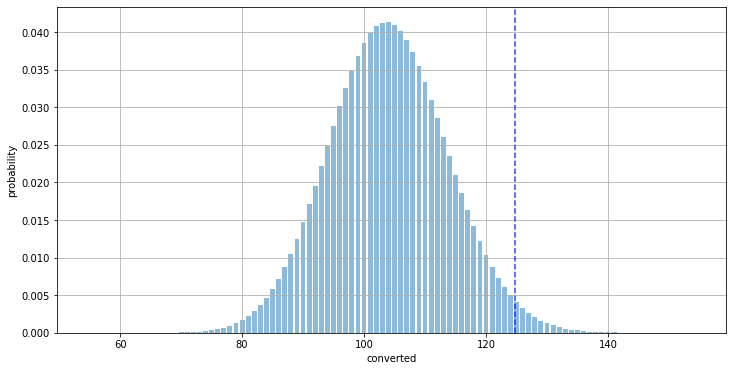

In [65]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(A_converted-49, A_converted+50, 100)
y = scs.binom(A_total, A_cr).pmf(x)
ax.bar(x, y, alpha=0.5)
ax.axvline(x=B_cr * A_total, c='blue', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')
plt.grid()

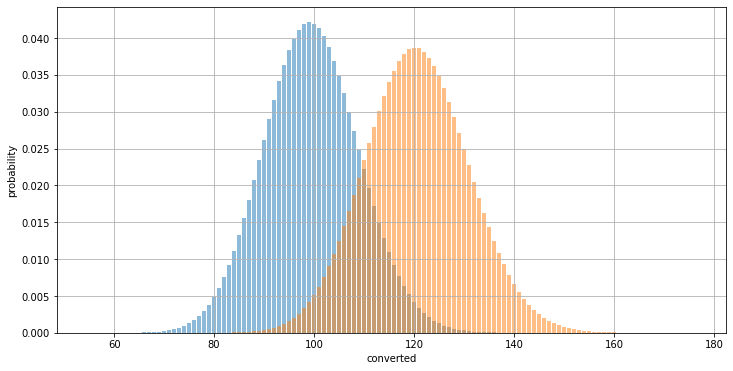

In [67]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(A_converted-49, A_converted+50, 100)
yA = scs.binom(A_total, p_A).pmf(xA)
ax.bar(xA, yA, alpha=0.5)
xB = np.linspace(B_converted-49, B_converted+50, 100)
yB = scs.binom(B_total, p_B).pmf(xB)
ax.bar(xB, yB, alpha=0.5)
plt.xlabel('converted')
plt.ylabel('probability')
plt.grid()

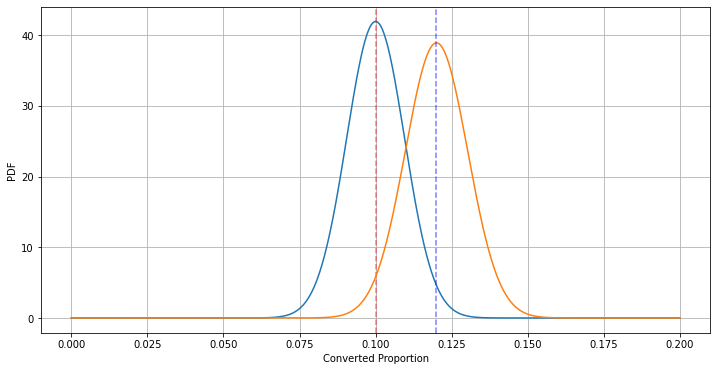

In [75]:
# standard error of the mean for both groups
SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(A_total)
SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(B_total)
# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(0, .2, 1000)
yA = scs.norm(p_A, SE_A).pdf(x)
ax.plot(x, yA)
ax.axvline(x=p_A, c='red', alpha=0.5, linestyle='--')
yB = scs.norm(p_B, SE_B).pdf(x)
ax.plot(x, yB)
ax.axvline(x=p_B, c='blue', alpha=0.5, linestyle='--')
plt.xlabel('Converted Proportion')
plt.ylabel('PDF')
plt.grid()

In [101]:
mt("$ \hat{d} = \hat{p_A} - \hat{p_A} = "+"{:.2f}.".format(p_B,p_A))

<IPython.core.display.Math object>